In [2]:
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [3]:
import pickle
train_data_file = "./data/mnist.pkl"
with open(train_data_file, "rb") as f:
    data = pickle.load(f)

train_data, test_data = torch.Tensor(data["train"]), torch.Tensor(data["test"])

In [40]:
class Discriminator(nn.Module):
    def __init__(self, in_shape, hidden_size):
        super(Discriminator, self).__init__()
        self.in_shape = in_shape
        self.nin = np.prod(in_shape)
        self.hidden_size = hidden_size

        self.disc = nn.Sequential(nn.Linear(self.nin, self.hidden_size), nn.LeakyReLU(0.1), nn.Linear(self.hidden_size, 1), nn.Sigmoid())
    def forward(self, X):
        return self.disc(X)

class Generator(nn.Module):
    def __init__(self, in_shape, hidden_size, latent_dim):
        super(Generator, self).__init__()
        self.in_shape = in_shape
        self.hidden_size = hidden_size
        self.nin = np.prod(in_shape)
        self.latent_dim = latent_dim

        self.gen = nn.Sequential(nn.Linear(self.latent_dim, self.hidden_size), nn.LeakyReLU(0.1), nn.Linear(self.hidden_size, self.nin), nn.Tanh())
    def forward(self ):
        X = torch.randn(32,self.latent_dim)
        return self.gen(X)

# class GAN(nn.Module):
#     def __init__(self, in_shape, hidden_size, latent_dim):
#         super(GAN, self).__init__()
#         self.in_shape = in_shape
#         self.hidden_size = hidden_size
#         self.latent_dim = latent_dim

#         self.gen = Generator(self.in_shape, self.hidden_size, self.latent_dim)
#         self.disc = Generator(self.in_shape, self.hidden_size, self.latent_dim)

#     def forward(self):
#         X = torch.randn(self.latent_dim)

#         generated = self.gen(X)

#         out = self.disc(generated)

#         return out

        

In [57]:
from random import random


num_epochs = 50
rec_loss = nn.MSELoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
disc = Discriminator((28,28,1), 256)
gen = Generator((28,28,1), 256, 64)
optim_disc = torch.optim.Adam(disc.parameters(), lr=3e-4)
optim_gen = torch.optim.Adam(gen.parameters(), lr=3e-4)
loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
loss_fn = nn.BCELoss()
k_steps_disc = 4
batch_size = 32
losses = []
for ep in trange(num_epochs):
    for src in loader:
        src[src > 0] = 1.
        optim_disc.zero_grad()
        optim_gen.zero_grad()
        real = src.view(src.shape[0], -1)
        # print("REAL: ",real.shape)
        fake = gen()
        # print("FAKE: ", fake.shape)


        real_preds = disc(real)
        fake_preds = disc(fake)

        disc_loss_real = loss_fn(real_preds, torch.ones_like(real_preds))
        disc_loss_fake = loss_fn(fake_preds, torch.zeros_like(fake_preds))

        disc_loss = (disc_loss_fake + disc_loss_real) / 2
        disc_loss.backward(retain_graph=True)
        optim_disc.step()


        out = disc(fake)
        loss_gen = loss_fn(out, torch.ones_like(out))
        loss_gen.backward()
        optim_gen.step()






100%|██████████| 50/50 [11:35<00:00, 13.92s/it]


In [58]:
from torchvision.utils import make_grid
def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)


    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        print("Yow")
    else:
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 28, 28, 1])


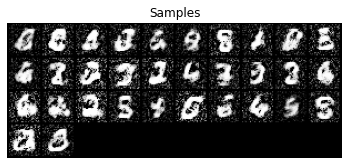

In [59]:
fixed_noise = torch.randn(batch_size, 64)
with torch.no_grad():
    fake = gen()
    fake = fake.reshape(32, 28,28,1)
    print(fake.shape)
    show_samples(fake)
